<a href="https://colab.research.google.com/github/VasiaKoum/Pattern-Recognition-ML/blob/main/image_season_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pattern recognition using machine learning<br>
# Dimensional Reduction Methods<br>

Parth Doshi 

University of California, Los Angeles

Winter 2023

In this project, I implemented machine learning algorithms in Python to interpret their results on real data (images) and synthetic data.

### Data Path

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
inputdir = "/content/drive/MyDrive/ML/images"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries used

In [ ]:
import os
import sys
import cv2                                                      # images
import matplotlib.pyplot as plt                                 # plots
import numpy as np                                              # linear algebra
import pandas as pd                                             # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA                           # for PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox    
from sklearn.model_selection import train_test_split            # for split
import sklearn.metrics as metrics                               # for accuracy
from sklearn.neighbors import KNeighborsClassifier              # for KNN
from sklearn.model_selection import cross_val_score             # for 5-fold cross validation
import numpy.linalg as LA                                       # for frobenius norm
from sklearn.model_selection import KFold                       # check splits

### Data Path Control

In [ ]:
if os.path.exists(inputdir) and os.path.isdir(inputdir):
    if not os.listdir(inputdir):
        print("Input directory is empty")
        sys.exit()
else:
    print("Input directory doesn't exist")
    sys.exit()


### Additional functions:
* #### The *filenameSeason* function takes the first character from the image name as input and returns the label number of the corresponding season. (Winter: 0, Autumn: 1, Spring: 2)
* #### Meanwhile, the function *getImageNames* takes as input the path of the input folder and returns an array with the names of the images read.

In [ ]:
# get the first letter and returns number of season
def filenameSeason(firstLetter):
    switcher={
        'W': 0,
        'F': 1,
        'S': 2
    }
    return switcher.get(firstLetter[0])

def addImageNamesToArray(image_array, path):
    names = []
    for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                names.append(os.path.join(dirname, filename))
    new_array = np.vstack([image_array, names])
    return new_array

def getImages(names):
    return OffsetImage(plt.imread(names), zoom=0.2)

## Pre-processing, dimensionality reduction, and image visualization and classification
Data: The dataset consists of 30 color RGB images capturing landscapes during spring, fall and winter (10 images for each season). The first letter in the file name of each image identifies the time when the image was captured, e.g. image F1.jpg was captured in fall while image W10.jpg was captured in winter.
So, the name of the files determines the category of the season to which it belongs for each image. Images are made up of different pixels. Each pixel consists of three color values ​​ranging between 0 and 255, defining the brightness intensity of red, green and blue, respectively, for each pixel. The data is available in the images.zip file. 

### <strong>loadImages(path)</strong> function
Then, I write a loadImages(path) function which takes the path where the images folder is located as input, e.g. loadImages(“C:/images”), reads the images, converts them to 100 x 100 pixels dimension, and returns a 30-column data table, where each image is represented as a column vector. The function also returns the labels to which the different images are belong encoded with integers (eg 0 for photos taken in winter, 1 for photos taken in autumn and 2 for those taken in spring).

In [ ]:
def loadImages(path):
    images_array = []
    labels_array = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            pathname = os.path.join(dirname, filename)
            img = cv2.imread(pathname)
#             100 x 100 pixels and flatten the 3d array
            resize_img = cv2.resize(img, (100, 100)).flatten()
#             append all images array to array
            images_array.append(resize_img)
#             append all labels to array
            labels_array.append(filenameSeason(filename))
    images_array = np.array(images_array).transpose()
    labels_array = np.array(labels_array)
    return images_array, labels_array

### <strong>PCA_ImageSpaceVisualization(X)</strong> function
Writing a function PCA_ImageSpaceVisualization(X) that takes as input the data matrix, calculates the first two principal components of the data and displays the data in the first two principals components. The function returns a plot in which the images in two-dimensional space resulting from the projection of the data onto the first two main components.

In [ ]:
def PCA_ImageSpaceVisualization(X):
    paths = X[-1, :]
    X = np.delete(X, (-1), axis=0).astype(np.int)
#     compute a PCA
    X = X.transpose()
    pca = PCA(n_components=2, whiten=True).fit(X)
    components = pca.transform(X)
#     original_data = pca.inverse_transform(components)
    x = components[:,0]
    y = components[:,1]
    
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.set_ylim([-3.5, 3.5])
    ax.scatter(x, y)
    for x0, y0, path in zip(x, y, paths):
        ab = AnnotationBbox(getImages(path), (x0, y0))
        ax.add_artist(ab)
    return components.transpose()

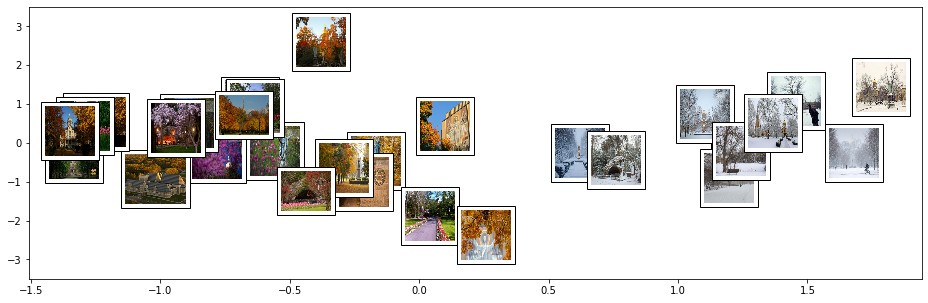

In [ ]:
#plot
images_array, labels_array = loadImages(inputdir)
images_array = addImageNamesToArray(images_array, inputdir)
components = PCA_ImageSpaceVisualization(images_array)

### Location of the images
What does it mean when images are close to this two-dimensional space depicted in the plot above? What does it mean when images are far apart? Can we generalize these conclusions to the original image space which is a very high dimensional?

The PCA method reduces the feature dimensions without losing the dispersion of the data. Since the data is about images, their attributes are the RGB values ​​for each pixel. The diagram above shows the first two principal components of all pixels for each image. This means that images that are close to this 2-dimensional space have, collectively, similar colors.
Contrarily, the images that are very far from each other, correspondingly have PCA numbers that are also far apart, with the consequence that their (total) color rendering differs a lot. For higher dimensional space (d>3) we cannot infer the distance between data due to the lack of locality exhibited by high dimensional data (there is no concept of "close").


### Grouping the images

Then, I wondered whether images corresponding to one of the seasons tend to cluster closer together than the others? If so, why?

In [ ]:
comp = components.transpose()
dataf = pd.DataFrame(data=comp,index=labels_array,columns=["x","y"])  # 1st row as the column names
print(dataf[(dataf.x > 0.5)])

          x         y
0  0.622237 -0.269713
0  1.679015 -0.253981
0  1.239871 -0.208810
0  1.455458  1.066350
0  1.105008  0.739733
0  1.195554 -0.911240
0  1.784715  1.451475
0  1.244241 -0.208872
0  0.759750 -0.446291
0  1.366890  0.513223


As mentioned above, images that are close to two-dimensional space are close to PCA, resulting in color similarity. Thus, in the diagram, a group of images has been formed (on the right), which are mainly white in color and represent winter. This is proven by the dataframe above by applying a filter x>0.5 (x&y the two main components), all winter images are printed (with label=0). To the left and center are the images representing spring and autumn, which are not so different in color as to be accurately grouped and thus overlap.

### Calculating kNN for k = 1 and k = 3 for the data set 
Comparing the classification accuracy of the nearest-neighbor (1-NN) classifier and the three-nearest-neighbor (3-NN) classifier in the problem of identifying the epoch in which an image was captured. In other words, comparing the performance (in terms of classification accuracy) of the above classifiers in classifying the image data into winter, spring and autumn categories.


Solving the sorting problem using the original large-dimension images in vector format and characteristics of low dimension to output using PCA. 

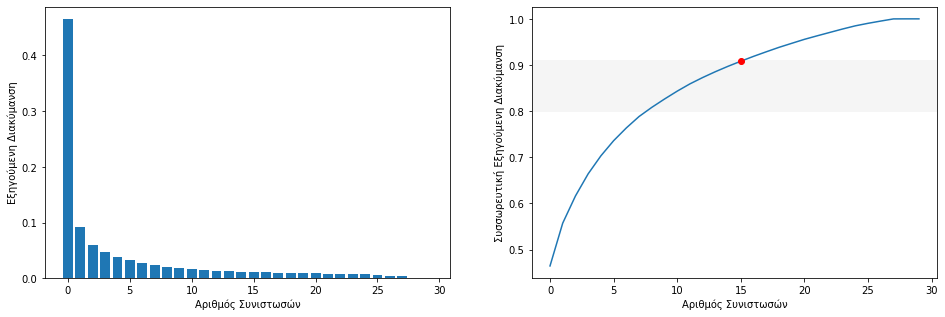

In [ ]:
def PCA_nComponents(X):
    paths = X[-1, :]
    X = np.delete(X, (-1), axis=0).astype(np.int)
    X = X.transpose()
    components = 30
    
#     compute a PCA    
    pca = PCA(n_components=components, whiten=True).fit(X)
    cumExplainedVar=np.cumsum(pca.explained_variance_ratio_)
    max_components = np.argwhere((cumExplainedVar > 0.90) & (cumExplainedVar < 0.91)).flatten()[0]

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(components),pca.explained_variance_ratio_[:components])
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance');

    plt.subplot(1, 2, 2)
    for i in np.arange(0.8,0.91,0.001):
        plt.axhline(y=i, color= "whitesmoke")
    plt.plot(cumExplainedVar)
    plt.plot(max_components,cumExplainedVar[max_components],'ro') 
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance');
    plt.show()

    pca = PCA(n_components=max_components, whiten=True).fit(X)
    components = pca.transform(X)
    return components.transpose(), cumExplainedVar
    
components_new, cumExplainedVar = PCA_nComponents(images_array)

In [ ]:
def foldCrossVal(train_set, correct_labels, neighbors):
    train_set = train_set[:-1, :].astype(np.float64)
    train_set = train_set.transpose()
    
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(train_set):
        per_0=100 * round(np.count_nonzero((correct_labels[train_index])==0)/correct_labels[train_index].size, 4)
        per_1=100 * round(np.count_nonzero((correct_labels[train_index])==1)/correct_labels[train_index].size, 4)
        per_2=100 * round(np.count_nonzero((correct_labels[train_index])==2)/correct_labels[train_index].size, 4)
        print("Label = 0", per_0, "Label = 1", per_1, "Label = 2", per_2)
    

    # create a new KNN model
    knn_ = KNeighborsClassifier(n_neighbors=neighbors)
    # train model with cross validation of 5
    knn_scores = cross_val_score(knn_, train_set, labels_array, cv=kf)
    # accuracy percent
    return 100 * round(np.mean(knn_scores), 4),knn_scores

Using 5-fold cross validation and reporting the average classification accuracy for the two classifiers for both the original high-dimensional data and the low-dimensional features extracted using PCA.

In [ ]:
all_knn1,all_knn1_scores = foldCrossVal(images_array, labels_array, 1)
all_knn3,all_knn3_scores = foldCrossVal(images_array, labels_array, 3)
pca_knn1,pca_knn1_scores = foldCrossVal(components_new, labels_array, 1)
pca_knn3,pca_knn3_scores = foldCrossVal(components_new, labels_array, 3)

print("\n")
print("All data KNN k=1 ->", str(all_knn1)+"%")
print("All data KNN k=3 ->", str(all_knn3)+"%")
print("PCA data KNN k=1 ->", str(pca_knn1)+"%")
print("PCA data KNN k=3 ->", str(pca_knn3)+"%")

Label = 0 33.33 Label = 1 33.33 Label = 2 33.33
Label = 0 37.5 Label = 1 33.33 Label = 2 29.17
Label = 0 37.5 Label = 1 29.17 Label = 2 33.33
Label = 0 29.17 Label = 1 37.5 Label = 2 33.33
Label = 0 29.17 Label = 1 33.33 Label = 2 37.5
Label = 0 33.33 Label = 1 33.33 Label = 2 33.33
Label = 0 37.5 Label = 1 33.33 Label = 2 29.17
Label = 0 37.5 Label = 1 29.17 Label = 2 33.33
Label = 0 29.17 Label = 1 37.5 Label = 2 33.33
Label = 0 29.17 Label = 1 33.33 Label = 2 37.5
Label = 0 33.33 Label = 1 33.33 Label = 2 33.33
Label = 0 37.5 Label = 1 33.33 Label = 2 29.17
Label = 0 37.5 Label = 1 29.17 Label = 2 33.33
Label = 0 29.17 Label = 1 37.5 Label = 2 33.33
Label = 0 29.17 Label = 1 33.33 Label = 2 37.5
Label = 0 33.33 Label = 1 33.33 Label = 2 33.33
Label = 0 37.5 Label = 1 33.33 Label = 2 29.17
Label = 0 37.5 Label = 1 29.17 Label = 2 33.33
Label = 0 29.17 Label = 1 37.5 Label = 2 33.33
Label = 0 29.17 Label = 1 33.33 Label = 2 37.5


All data KNN k=1 -> 80.0%
All data KNN k=3 -> 66.67%
P

Determining the dimensionality of the features extracted through PCA by calculating the cumulative explained variance. The number of principal components where they explain about 80%-90% are:

In [ ]:
comps = np.argwhere((cumExplainedVar > 0.80) & (cumExplainedVar < 0.91)).flatten()
print("The number of principal components(80%-90%)-> ",comps)
print("The largest number of principal components(~90%)-> ", max(comps))

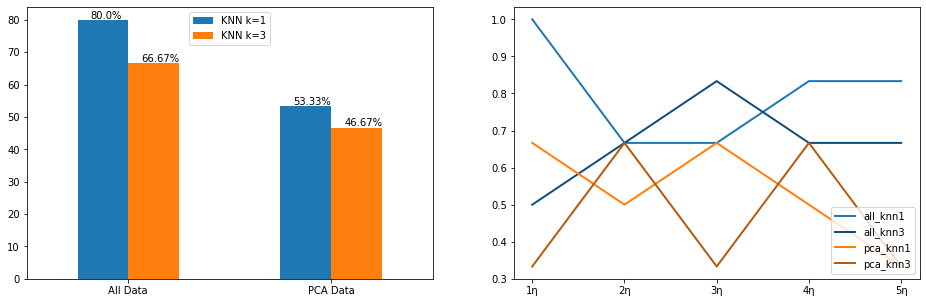

In [ ]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(121)

# PLOT 1
X = ['All Data', 'PCA Data']
Y = [all_knn1, pca_knn1]
Z = [all_knn3, pca_knn3]
df = pd.DataFrame(np.c_[Y,Z], index=X)
df.plot.bar(ax=ax)
plt.xticks(rotation=360)
ax.legend(('KNN k=1', 'KNN k=3'),loc="upper center")
for patch in ax.patches:
    bbox = patch.get_bbox()
    val = "{:}%".format(bbox.y1)        
    ax.annotate(val, ((bbox.x0 + bbox.x1)/2 + -0.06, bbox.y1 + 0.5))

# PLOT 2
ax = fig.add_subplot(122)
labels=["1st", "2nd", "3rd", "4th", "5th"]
plt.plot(all_knn1_scores, label="all_knn1", color="#1f77b4",linewidth=2)
plt.plot(all_knn3_scores, label="all_knn3", color="#0d4e7b",linewidth=2)
plt.plot(pca_knn1_scores, label="pca_knn1", color="#ff7f0e",linewidth=2)
plt.plot(pca_knn3_scores, label="pca_knn3", color="#b55b0c",linewidth=2)
plt.legend(loc="lower right")
plt.xticks(range(len(labels)), labels)

# Show plots
plt.show()

## Normalized non-negative factorization of matrices
Considering the following optimization problem for regularized non-negative matrix factorization (regNMF)::
<br><br>
$min_{A,B}∥X − AB∥^2_F + \lambda∥A∥^2_F s.t.A ≥ 0, B ≥ 0$
<br>

The problem obviously has no closed-form solution and therefore must be solved iteratively

### <strong> Multiplicative renewal rules</strong><br>
The avove optimization problem: $min_{A,B}∥X − AB∥^2_F + \lambda∥A∥^2_F s.t.A ≥ 0, B ≥ 0$
has no closed solution and will be solved iteratively with the gradient descent step method. Therefore I find the following should be found:<br>
$A_{[t+1]}=A_{t}-n_{A_t}∇_{A_{[t]}}ℓ(A_{t},B)$
$B_{[t+1]}=B_{t}-n_{B_t}∇_{B_{[t]}}ℓ(A,B_{t})$  <br><br>
Properties to be used in simplification:<br>
1) $∇_x Tr(AX)=A^T$

2) $ ∥X∥_F=\sqrt{Tr(X^TX)}$

3) $∇_x Tr(X^TA)=A$

4) $∇_x Tr(XAX^T)=X(A+A^T)$

5) $Tr(AB)=Tr(BA)$

<br>
Simplifying the optimization problem 

 $∥X − AB∥^2_F + \lambda∥A∥^2_F$    <br>

 Using property 2:<br><br>
 
$Tr((X − AB)^T(X − AB)) + \lambda Tr(A^TA)=$    <br>

$Tr((X^T − B^TA^T)(X − AB)) + \lambda Tr(A^TA)=$<br>

$Tr(X^TX - X^TAB - B^TA^TX + B^TA^TAB) + \lambda Tr(A^TA)=$<br>

$Tr(X^TX) - Tr(X^TAB) - Tr(B^TA^TX) + Tr(B^TA^TAB) + \lambda Tr(A^TA)$<br><br>
Calculating the derivative: 
$∇\left[Tr(X^TX) - Tr(X^TAB) - Tr(B^TA^TX) + Tr(B^TA^TAB) + \lambda Tr(A^TA)\right]$<br>

**Derivative wrt A:**<br><br>
$∇_Aℓ(A_{t},B) = 0  - XB^T - XB^T + 2ABB^T + 2\lambda A\Rightarrow$
$∇_Aℓ(A_{t},B) = - 2XB^T +2A(BB^T + \lambda)$

Defining as $n_{A_t} = \dfrac{A}{A(BB^T+\lambda)}$

By substitution (for convenience we define $A = A_{t}$):<br>
> $A_{[t+1]}=A_{t}-n_t∇_{A_{[t]}}ℓ(A_{t},B)\Rightarrow$<br><br>
$A_{[t+1]}=A-\dfrac{A}{A(BB^T+\lambda)}\left[- XB^T +2A(BB^T + \lambda)\right]\Rightarrow$<br><br>
$A_{[t+1]}=A+\dfrac{AXB^T}{A(BB^T+\lambda)}-\dfrac{AA(BB^T + \lambda)}{A(BB^T+\lambda)}\Rightarrow$<br><br>
$A_{[t+1]}=A+\dfrac{AXB^T}{A(BB^T+\lambda)}-A\Rightarrow$<br><br>
$A_{[t+1]}=\dfrac{AXB^T}{A(BB^T+\lambda)}\Rightarrow$<br><br>
$A_{[t+1]}=A_{[t]}*\dfrac{XB^T}{A_{[t]}ΒΒ^Τ+\lambda A_{[t]}}\Rightarrow$<br><br>
___

**Derivative wrt B:**<br><br>
$∇_Βℓ(A,B_{t}) = 0 - A^TX - A^TX + A^TAB + A^TAB + 0\Rightarrow$
$∇_Βℓ(A,B_{t}) = - 2A^TX + 2A^TAB$

Defining as $n_{B_t} = \dfrac{B}{A^TAB}$

By substitution (for convenience we define $B = B_{t}$):<br>
> $Β_{[t+1]}=Β_{t}-n_t∇_{Β_{[t]}}ℓ(Α,Β_{t})\Rightarrow$<br><br>
$Β_{[t+1]}=Β-\dfrac{B}{A^TAB}\left(-A^TX + A^TAB\right)\Rightarrow$<br><br>
$Β_{[t+1]}=Β+\dfrac{BA^TX}{A^TAB}-\dfrac{BA^TAB}{A^TAB}\Rightarrow$<br><br>
$Β_{[t+1]}=Β+\dfrac{BA^TX}{A^TAB}-B\Rightarrow$<br><br>
$Β_{[t+1]}=\dfrac{BA^TX}{A^TAB}\Rightarrow$<br><br>
$Β_{[t+1]}=Β_{[t]}*\dfrac{A^TX}{A^TAB_{[t]}}\Rightarrow$<br><br>


Thus, the gradient descent step is defined as:<br><br>
$A_{[t+1]}=A_{[t]}*\dfrac{XB^T}{A_{[t]}BB^Τ+\lambda A_{[t]}}$<br>
$Β_{[t+1]}=Β_{[t]}*\dfrac{A^TX}{A^TAΒ_{[t]}}$

### <strong>RegNMF(X,k,lambda,epsilon)</strong> function
Implement an iterative algorithm in the function RegNMF(X,k,lambda,epsilon) to solve the above optimization problem using the multiplicative renewal rules I found. The function takes as input a non-negative matrix X of dimensions d x N, the number of components k, and the value of the normalization parameter λ (lambda) and the termination threshold ε (epsilon) and returns the non-negative matrices A of dimension d x k and B of dimension k x N. To determine whether an iterative algorithm converges to a solution, we typically monitor the reconstruction error:

$\epsilon = \dfrac{||Χ – A[t]B[t]||_F^2}{||X||_F^2}$

at each iteration if its change between two successive iterations is less than a threshold ε, i.e. if:

$\dfrac{||Χ – A[t-1]B[t-1]||_F^2 - ||Χ – A[t]B[t]||_F^2 }{||X||_F^2}≤\epsilon$

we terminate the algorithm and say that the algorithm has converged to a solution. The t in the above relation stands for the repetition index.<br>

Studying the convergence of the algorithm using synthetic data. To this end, I construct a 500 x 500 matrix X with non-negative values ​​as the product of two random matrices X = WH, with W having dimensions 500 x 10 and H having dimensions 10 x 500. To ensure that the array elements are non-negative I applied an absolute value operator to each element of the random array produced by the rand function. Using a fixed value for the parameter $\lambda$=0.5 studying the behavior of the regNMF algorithm in terms of the number of iterations required to converge if k= 5, 10, 50 and ε = 0.1, 0.01, 0.001.

k:  5  epsilon:  0.1  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  5  epsilon:  0.01  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  5  epsilon:  0.001  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  9
k:  10  epsilon:  0.1  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  10  epsilon:  0.01  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  10  epsilon:  0.001  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  4
k:  50  epsilon:  0.1  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  50  epsilon:  0.01  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  50  epsilon:  0.001  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3


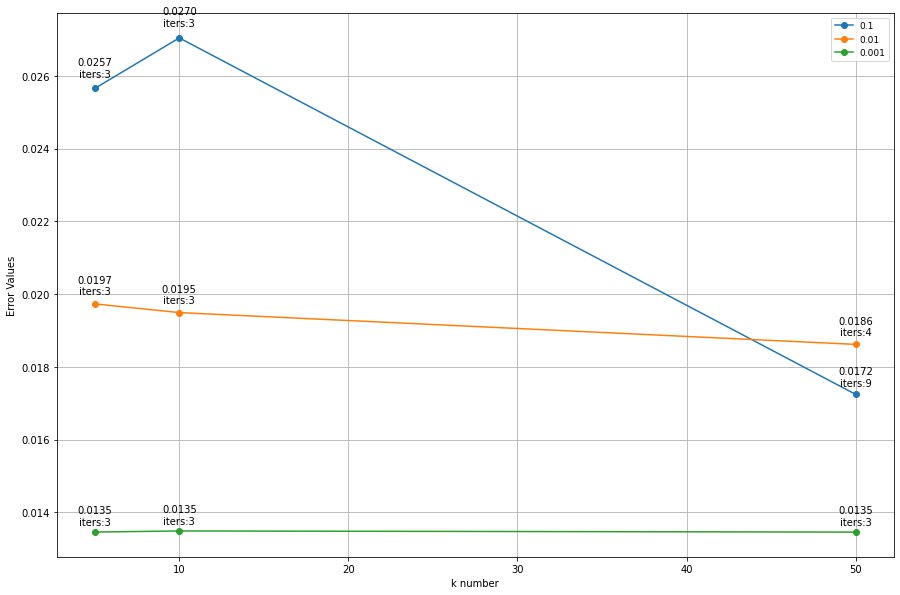

In [ ]:
def reconstrError(X,A,B,l):
    err_1 = np.square(LA.norm(X - np.dot(A, B), 'fro'))+l*np.square(LA.norm(A, 'fro'))+l*np.square(LA.norm(B, 'fro'))
    err_2 = np.square(LA.norm(X, 'fro'))
    err = err_1/err_2
    return err

def update_A(X,A,B,l):
    numerator = X.dot(B.T)
    denominator = A.dot(B.dot(B.T)+l) 
    A *= numerator
    A /= denominator
    return A

def update_B(X,A,B,l):
    numerator = np.dot(A.T, X)
    denominator = np.dot(A.T.dot(A),B)
    B *= numerator
    B /= denominator
    return B


def RegNMF(X,k,l,epsilon):
    A = np.random.rand(np.size(X, 0), k)
    B = np.random.rand(k, np.size(X, 1))
    e = reconstrError(X,A,B,l)
    error = []
    error.append(e)
    i=1
    
    while e>=epsilon:
        Aup = update_A(X,A,B,l)
        Bup = update_B(X,A,B,l)
        e1 = reconstrError(X,Aup,Bup,l)
        e2 = error[-1]
        e = abs(e1-e2)
        error.append(e1)
        i+=1
    print("k: ", k, " epsilon: ", epsilon, " lambda: ",l," REPITITIONS: ", i)
    return Aup,Bup,error,i

def runRegNMF(X, l, k, epsilon):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    for count_i, i in enumerate(k):
        errors = []
        iters = []
        for count_j, j in enumerate(epsilon):
            Anew, Bnew, error, iter = RegNMF(X, i, l, j)
            errors.append(error[-1])
            iters.append(iter)
            
        plt.plot(k, errors, marker='o')
        plt.ylabel("Error Values")
        plt.xlabel("k number")
        for points in zip(k,errors,iters):                                      
            ax.annotate('{:.4f}\niters:{}'.format(points[1], points[2]), xy=[points[0], points[1]], textcoords='data', ha='center', va='bottom', xytext=(points[0], points[1]*1.01))
        plt.legend(epsilon, fontsize=9, loc = 'upper right')
    plt.grid()
    plt.show()

k = [5, 10, 50]
epsilon = [0.1, 0.01, 0.001]
np.random.seed(74)
W = np.abs(np.random.rand(500, 10))
H = np.abs(np.random.rand(10, 500))
X = W.dot(H)

runRegNMF(X, 0.5, k, epsilon)

k:  5  epsilon:  0.1  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  5  epsilon:  0.05  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  5  epsilon:  0.01  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  5  epsilon:  0.005  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  5  epsilon:  0.0001  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  31
k:  10  epsilon:  0.1  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  10  epsilon:  0.05  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  10  epsilon:  0.01  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  10  epsilon:  0.005  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  10  epsilon:  0.0001  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  29
k:  20  epsilon:  0.1  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  20  epsilon:  0.05  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  20  epsilon:  0.01  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  20  epsilon:  0.005  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  20  epsilon:  0.0001  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  20
k:  40  epsilon:  0.1  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  40  epsilon:  0.05  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  40  epsilon:  0.01  lambda:  0.5  ΕΠΑΝΑΛΗΨΕΙΣ:  3
k:  40  epsilon:  0.005  

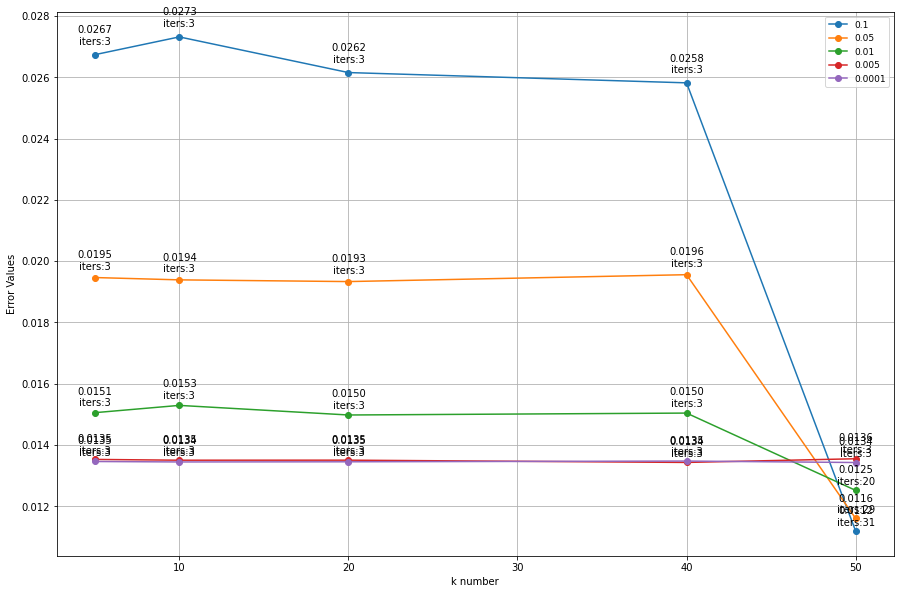

In [ ]:
k = [5, 10, 20, 40, 50]
epsilon = [0.1, 0.05, 0.01, 0.005, 0.0001]
runRegNMF(X, 0.5, k, epsilon)

Observations:
* As k increases, so does the number of iterations for $\epsilon=0.1$ και $\epsilon=0.01$. This is because the array has a larger k value so more iterations will be needed to converge the error to the desired value. 
* For large $\epsilon$ values and as k increases, the error decreases more rapidly but it takes more iterations to achieve this. Also, we notice that for $\epsilon\leq0.005$ the error remains constant while for larger $\epsilon$ and larger k values, the error reaches smaller values.


References:<br>
* https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf
* https://www.jjburred.com/research/pdf/jjburred_nmf_updates.pdf
* https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
* https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0046331